<a href="https://colab.research.google.com/github/Ravi-Koppula/Dementia_Classification/blob/main/minor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, new_size):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each class folder in the input directory
    for class_folder in os.listdir(input_dir):
        if os.path.isdir(os.path.join(input_dir, class_folder)):
            class_input_dir = os.path.join(input_dir, class_folder)
            class_output_dir = os.path.join(output_dir, class_folder)
            os.makedirs(class_output_dir, exist_ok=True)

            # Loop through each image file in the class folder
            for filename in os.listdir(class_input_dir):
                if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more formats if needed
                    # Open the image
                    image_path = os.path.join(class_input_dir, filename)
                    with Image.open(image_path) as img:
                        # Resize the image
                        resized_img = img.resize(new_size)

                        # Save the resized image
                        output_path = os.path.join(class_output_dir, filename)
                        resized_img.save(output_path)

    print("Image resizing complete.")

# Set the directory containing the images
input_dir = "/content/drive/MyDrive/DATASET"
output_dir = "/content/drive/MyDrive/DATA299"
new_size = (299, 299)  # Define the new size of the images

# Resize the images
resize_images(input_dir, output_dir, new_size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to ratio, i.e, (.8, .2).
splitfolders.ratio("/content/drive/MyDrive/DATA299", output="/content/drive/MyDrive/DATA299SPLIT",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values

Copying files: 1409 files [11:24,  2.06 files/s]


Training and evaluating on Image_Data...
Found 986 images belonging to 2 classes.
Found 211 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/100
31/31 [==============================] - 384s 11s/step - loss: 0.1711 - accuracy: 0.9199 - val_loss: 36.9814 - val_accuracy: 0.4550
Epoch 2/100
31/31 [==============================] - 30s 972ms/step - loss: 0.0662 - accuracy: 0.9757 - val_loss: 31.6727 - val_accuracy: 0.4550
Epoch 3/100
31/31 [==============================] - 30s 966ms/step - loss: 0.0613 - accuracy: 0.9797 - val_loss: 82.4403 - val_accuracy: 0.4550
Epoch 4/100
31/31 [==============================] - 30s 964ms/step - loss: 0.0868 - accuracy: 0.9706 - val_loss: 2.0867 - val_accuracy: 0.8341
Epoch 5/100
31/31 [==============================] - 30s 976ms/step - loss: 0.0545 - accuracy: 0.9817 - val_loss: 6.0483 - val_accuracy: 0.7014
Epoch 6/100
31/31 [==============================

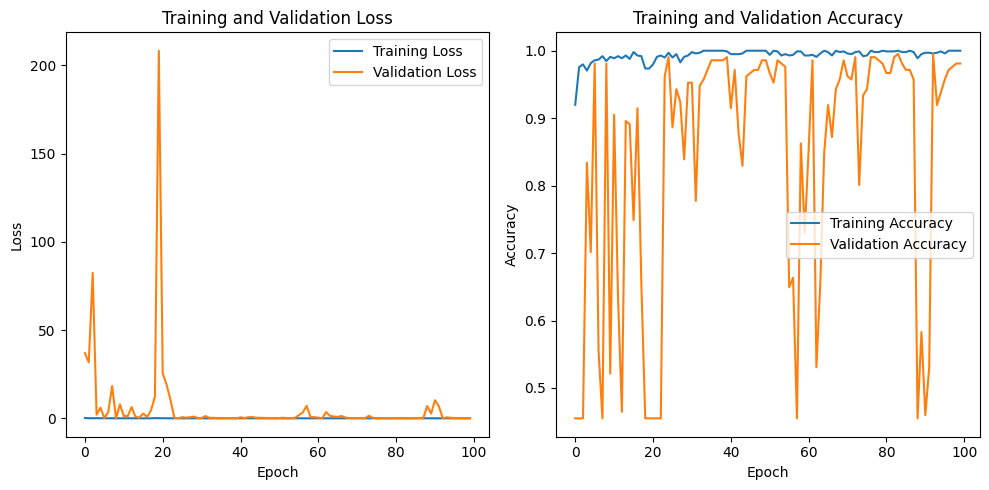

7/7 [==============================] - 3s 185ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       116
           1       0.45      0.47      0.46        96

    accuracy                           0.50       212
   macro avg       0.50      0.50      0.50       212
weighted avg       0.50      0.50      0.50       212

Confusion Matrix:
[[61 55]
 [51 45]]
ROC and AUC for Binary Class:
FPR: [0.         0.43965517 0.45689655 0.45689655 0.47413793 0.47413793
 0.49137931 0.49137931 0.5        0.5        0.51724138 0.51724138
 0.54310345 0.54310345 0.57758621 0.57758621 0.60344828 0.60344828
 0.62931034 0.62931034 0.64655172 0.64655172 0.65517241 0.65517241
 0.71551724 0.71551724 0.73275862 0.73275862 0.74137931 0.74137931
 0.75       0.75       0.76724138 0.76724138 0.77586207 0.77586207
 0.81896552 0.81896552 0.82758621 0.82758621 0.8362069  0.8362069
 0.85344828 0.85344828 0.86206897 0.86206897 0.87068966 0

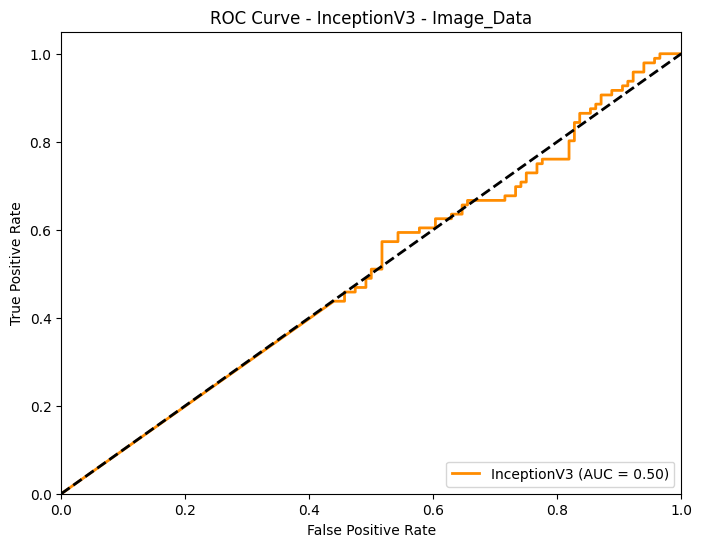

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Define the dataset directories
dataset_dirs = ['/content/drive/MyDrive/DATA299SPLIT']
dataset_names = ['Image_Data']

# Define common hyperparameters
img_width, img_height = 299, 299  # InceptionV3 requires input shape of 299x299
input_shape = (img_width, img_height, 3)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest')

# Data augmentation for validation and testing (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define a list of colors for plotting ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

# Loop over datasets
for dataset_dir, dataset_name in zip(dataset_dirs, dataset_names):
    print(f"Training and evaluating on {dataset_name}...")

    # Load and preprocess data for the current dataset
    train_data_dir ='/content/drive/MyDrive/DATA299SPLIT/train'
    val_data_dir = '/content/drive/MyDrive/DATA299SPLIT/val'
    test_data_dir = '/content/drive/MyDrive/DATA299SPLIT/test'

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    val_generator = val_test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    test_generator = val_test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    # Build and train the model
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

    custom_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Change the number of output units to 1 for binary classification
    ])

    custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss to 'binary_crossentropy'

    history = custom_model.fit(train_generator, epochs=100, validation_data=val_generator)
    validation_accuracy = history.history['val_accuracy'][-1]

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate the model on testing data
    loss, testing_accuracy = custom_model.evaluate(test_generator)

    # Make predictions using the model on the testing set
    preds = custom_model.predict(test_generator)
    class_preds = np.round(preds).flatten().astype(int)  # Round predictions for binary classification

    # Print classification report
    print("Classification Report:")
    print(classification_report(test_generator.classes, class_preds))

    # Compute the confusion matrix
    cm = confusion_matrix(test_generator.classes, class_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate ROC curve and AUC for the binary class
    fpr, tpr, _ = roc_curve(test_generator.classes, preds)
    roc_auc = auc(fpr, tpr)
    print("ROC and AUC for Binary Class:")
    print(f"FPR: {fpr}")
    print(f"TPR: {tpr}")
    print(f"AUC: {roc_auc}")

    # Plot ROC curve for the binary class
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'InceptionV3 (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - InceptionV3 - {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, new_size):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each class folder in the input directory
    for class_folder in os.listdir(input_dir):
        if os.path.isdir(os.path.join(input_dir, class_folder)):
            class_input_dir = os.path.join(input_dir, class_folder)
            class_output_dir = os.path.join(output_dir, class_folder)
            os.makedirs(class_output_dir, exist_ok=True)

            # Loop through each image file in the class folder
            for filename in os.listdir(class_input_dir):
                if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more formats if needed
                    # Open the image
                    image_path = os.path.join(class_input_dir, filename)
                    with Image.open(image_path) as img:
                        # Resize the image
                        resized_img = img.resize(new_size)

                        # Save the resized image
                        output_path = os.path.join(class_output_dir, filename)
                        resized_img.save(output_path)

    print("Image resizing complete.")

# Set the directory containing the images
input_dir = "/content/drive/MyDrive/DATASET"
output_dir = "/content/drive/MyDrive/DATA224"
new_size = (244, 244)  # Define the new size of the images

# Resize the images
resize_images(input_dir, output_dir, new_size)

Image resizing complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to ratio, i.e, (.8, .2).
splitfolders.ratio("/content/drive/MyDrive/DATASET", output="/content/drive/MyDrive/DATA224",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values


Copying files: 1409 files [00:28, 49.61 files/s]


Training and evaluating on Image_Data...
Found 986 images belonging to 2 classes.
Found 211 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/100
31/31 [==============================] - 253s 7s/step - loss: 0.1214 - accuracy: 0.9523 - val_loss: 10.5088 - val_accuracy: 0.4550
Epoch 2/100
31/31 [==============================] - 19s 604ms/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 10.5760 - val_accuracy: 0.4550
Epoch 3/100
31/31 [==============================] - 18s 592ms/step - loss: 0.0458 - accuracy: 0.9797 - val_loss: 9.0358 - val_accuracy: 0.4550
Epoch 4/100
31/31 [==============================] - 19s 600ms/step - loss: 0.0584 - accuracy: 0.9807 - val_loss: 2.2207 - val_accuracy: 0.5545
Epoch 5/100
31/31 [==============================] - 19s 605ms/step - loss: 0.0175 - accuracy: 0.9939 - val_loss: 6.7853 - val_accuracy: 0.4550
Epoch 6/100
31/31 [==============================] - 19s 597ms/step - loss: 0.0479 - accuracy: 0.9858 - val_loss: 0.1248 - val_accuracy: 0.9573
Epoch 7/100
31/31 [==============================] - 20s 638ms/step - l

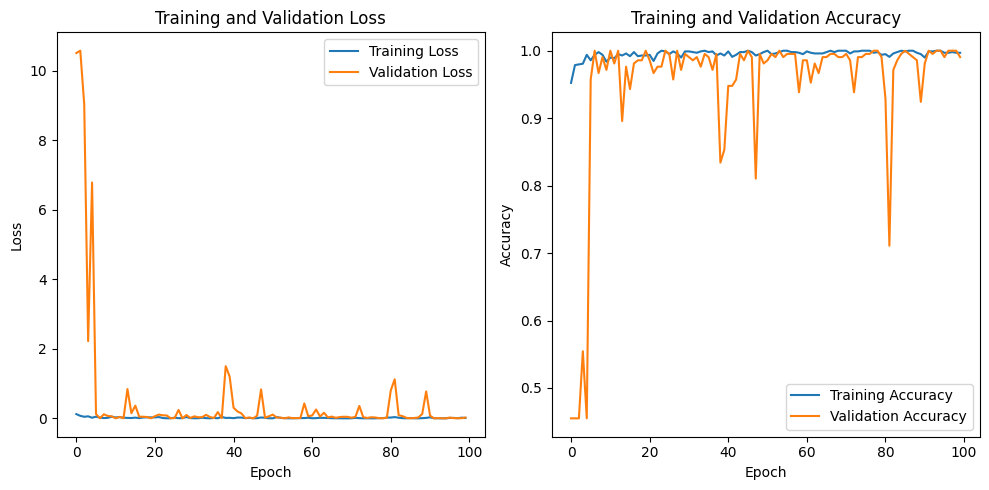

7/7 [==============================] - 1s 120ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       116
           1       0.47      0.43      0.45        96

    accuracy                           0.52       212
   macro avg       0.52      0.52      0.51       212
weighted avg       0.52      0.52      0.52       212

Confusion Matrix:
[[70 46]
 [55 41]]
ROC and AUC for Binary Class:
FPR: [0.         0.12931034 0.13793103 0.18965517 0.19827586 0.20689655
 0.21551724 0.21551724 0.22413793 0.24137931 0.25       0.25
 0.25862069 0.25862069 0.30172414 0.30172414 0.31034483 0.31034483
 0.32758621 0.32758621 0.3362069  0.3362069  0.35344828 0.35344828
 0.38793103 0.38793103 0.39655172 0.39655172 0.4137931  0.4137931
 0.47413793 0.47413793 0.48275862 0.48275862 0.49137931 0.49137931
 0.56034483 0.56034483 0.5862069  0.5862069  0.59482759 0.59482759
 0.60344828 0.60344828 0.61206897 0.61206897 0.62068966 0.62068

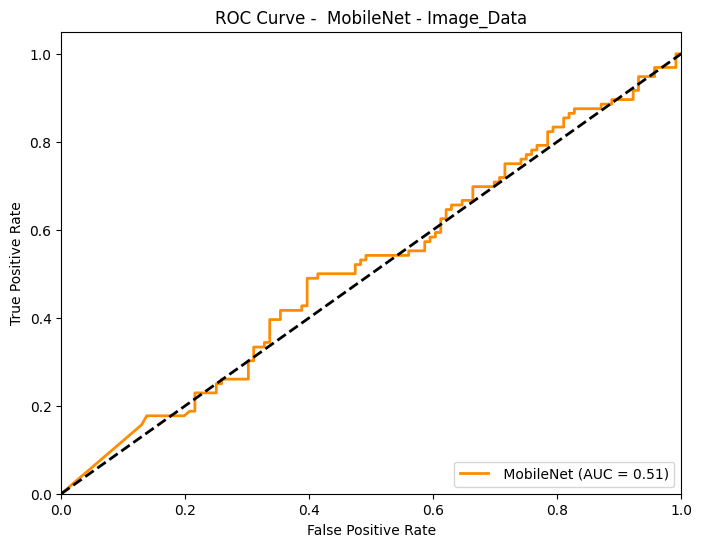

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Define the dataset directories
dataset_dirs = ['/content/drive/MyDrive/DATA224SPLIT']
dataset_names = ['Image_Data']

# Define common hyperparameters
img_width, img_height = 244, 244  #MobileNet requires input shape of 299x299
input_shape = (img_width, img_height, 3)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest')

# Data augmentation for validation and testing (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define a list of colors for plotting ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

# Loop over datasets
for dataset_dir, dataset_name in zip(dataset_dirs, dataset_names):
    print(f"Training and evaluating on {dataset_name}...")

    # Load and preprocess data for the current dataset
    train_data_dir ='/content/drive/MyDrive/DATA224SPLIT/train'
    val_data_dir = '/content/drive/MyDrive/DATA224SPLIT/val'
    test_data_dir = '/content/drive/MyDrive/DATA224SPLIT/test'

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    val_generator = val_test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    test_generator = val_test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    # Build and train the model
    base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

    custom_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Change the number of output units to 1 for binary classification
    ])

    custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss to 'binary_crossentropy'

    history = custom_model.fit(train_generator, epochs=100, validation_data=val_generator)
    validation_accuracy = history.history['val_accuracy'][-1]

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate the model on testing data
    loss, testing_accuracy = custom_model.evaluate(test_generator)

    # Make predictions using the model on the testing set
    preds = custom_model.predict(test_generator)
    class_preds = np.round(preds).flatten().astype(int)  # Round predictions for binary classification

    # Print classification report
    print("Classification Report:")
    print(classification_report(test_generator.classes, class_preds))

    # Compute the confusion matrix
    cm = confusion_matrix(test_generator.classes, class_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate ROC curve and AUC for the binary class
    fpr, tpr, _ = roc_curve(test_generator.classes, preds)
    roc_auc = auc(fpr, tpr)
    print("ROC and AUC for Binary Class:")
    print(f"FPR: {fpr}")
    print(f"TPR: {tpr}")
    print(f"AUC: {roc_auc}")

    # Plot ROC curve for the binary class
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f' MobileNet (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve -  MobileNet - {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, new_size):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each class folder in the input directory
    for class_folder in os.listdir(input_dir):
        if os.path.isdir(os.path.join(input_dir, class_folder)):
            class_input_dir = os.path.join(input_dir, class_folder)
            class_output_dir = os.path.join(output_dir, class_folder)
            os.makedirs(class_output_dir, exist_ok=True)

            # Loop through each image file in the class folder
            for filename in os.listdir(class_input_dir):
                if filename.endswith(".jpg") or filename.endswith(".png"):  # Add more formats if needed
                    # Open the image
                    image_path = os.path.join(class_input_dir, filename)
                    with Image.open(image_path) as img:
                        # Resize the image
                        resized_img = img.resize(new_size)

                        # Save the resized image
                        output_path = os.path.join(class_output_dir, filename)
                        resized_img.save(output_path)

    print("Image resizing complete.")

# Set the directory containing the images
input_dir = "/content/drive/MyDrive/DATASET"
output_dir = "/content/drive/MyDrive/DATA240(B1)"
new_size = (240, 240)  # Define the new size of the images

# Resize the images
resize_images(input_dir, output_dir, new_size)

Image resizing complete.
Image resizing complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to ratio, i.e, (.8, .2).
splitfolders.ratio("/content/drive/MyDrive/DATASET", output="/content/drive/MyDrive/DATA240(B1)",
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False) # default values


Copying files: 1409 files [00:47, 29.58 files/s]


Training and evaluating on Image_Data...
Found 986 images belonging to 2 classes.
Found 211 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Epoch 1/100
31/31 [==============================] - 83s 809ms/step - loss: 0.1472 - accuracy: 0.9432 - val_loss: 0.8462 - val_accuracy: 0.4550
Epoch 2/100
31/31 [==============================] - 23s 746ms/step - loss: 0.1027 - accuracy: 0.9686 - val_loss: 1.3217 - val_accuracy: 0.4550
Epoch 3/100
31/31 [==============================] - 23s 720ms/step - loss: 0.0957 - accuracy: 0.9736 - val_loss: 0.8238 - val_accuracy: 0.4550
Epoch 4/100
31/31 [==============================] - 25s 797ms/step - loss: 0.0586 - accuracy: 0.9777 - val_loss: 0.7488 - val_accuracy: 0.4550
Epoch 5/100
31/31 [==============================] - 30s 955ms/step - loss: 0.0510 - accuracy: 0.9858 - val_loss: 0.8054 - val_accuracy: 0.4550
Epoch 6/100
31/31 [==============================] - 26s 831ms/step - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.

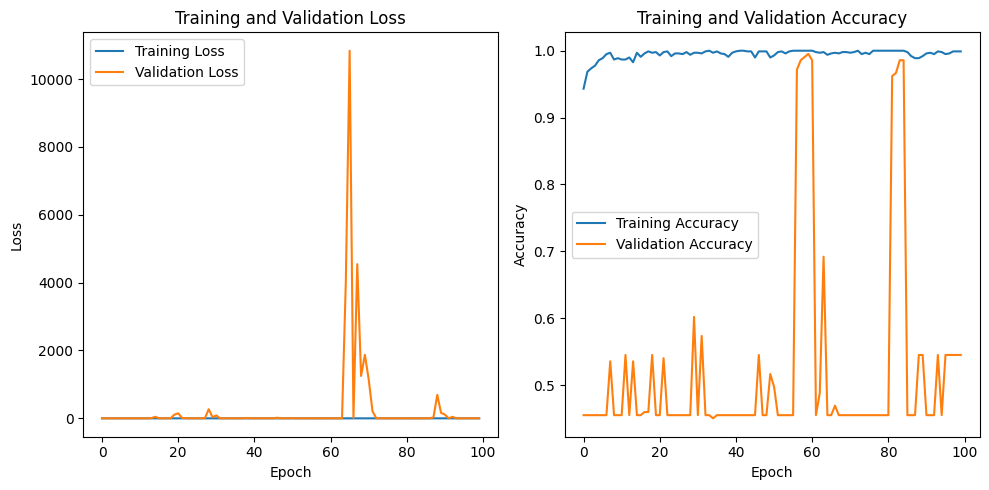

7/7 [==============================] - 3s 130ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       116
           1       0.00      0.00      0.00        96

    accuracy                           0.55       212
   macro avg       0.27      0.50      0.35       212
weighted avg       0.30      0.55      0.39       212

Confusion Matrix:
[[116   0]
 [ 96   0]]
ROC and AUC for Binary Class:
FPR: [0.         0.         0.00862069 0.00862069 0.01724138 0.01724138
 0.02586207 0.02586207 0.06896552 0.06896552 0.0862069  0.0862069
 0.10344828 0.10344828 0.11206897 0.11206897 0.12068966 0.12068966
 0.12931034 0.12931034 0.13793103 0.13793103 0.1637931  0.1637931
 0.17241379 0.17241379 0.20689655 0.20689655 0.21551724 0.21551724
 0.24137931 0.24137931 0.28448276 0.28448276 0.31034483 0.31034483
 0.32758621 0.32758621 0.36206897 0.36206897 0.39655172 0.39655172
 0.42241379 0.42241379 0.43965517 0.43965517 0.4482758

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


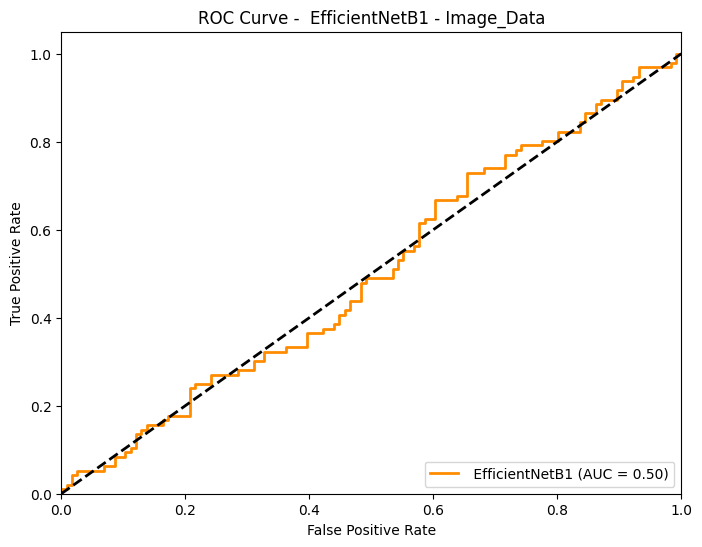

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Define the dataset directories
dataset_dirs = ['/content/drive/MyDrive/DATA240(B1)SPLIT']
dataset_names = ['Image_Data']

# Define common hyperparameters
img_width, img_height = 244, 244  #MobileNet requires input shape of 299x299
input_shape = (img_width, img_height, 3)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest')

# Data augmentation for validation and testing (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define a list of colors for plotting ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

# Loop over datasets
for dataset_dir, dataset_name in zip(dataset_dirs, dataset_names):
    print(f"Training and evaluating on {dataset_name}...")

    # Load and preprocess data for the current dataset
    train_data_dir ='/content/drive/MyDrive/DATA240(B1)SPLIT/train'
    val_data_dir = '/content/drive/MyDrive/DATA240(B1)SPLIT/val'
    test_data_dir = '/content/drive/MyDrive/DATA240(B1)SPLIT/test'

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    val_generator = val_test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    test_generator = val_test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')  # Set class_mode to 'binary'

    # Build and train the model
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, weights='imagenet')

    custom_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Change the number of output units to 1 for binary classification
    ])

    custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss to 'binary_crossentropy'

    history = custom_model.fit(train_generator, epochs=100, validation_data=val_generator)
    validation_accuracy = history.history['val_accuracy'][-1]

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate the model on testing data
    loss, testing_accuracy = custom_model.evaluate(test_generator)

    # Make predictions using the model on the testing set
    preds = custom_model.predict(test_generator)
    class_preds = np.round(preds).flatten().astype(int)  # Round predictions for binary classification

    # Print classification report
    print("Classification Report:")
    print(classification_report(test_generator.classes, class_preds))

    # Compute the confusion matrix
    cm = confusion_matrix(test_generator.classes, class_preds)
    print("Confusion Matrix:")
    print(cm)

    # Calculate ROC curve and AUC for the binary class
    fpr, tpr, _ = roc_curve(test_generator.classes, preds)
    roc_auc = auc(fpr, tpr)
    print("ROC and AUC for Binary Class:")
    print(f"FPR: {fpr}")
    print(f"TPR: {tpr}")
    print(f"AUC: {roc_auc}")

    # Plot ROC curve for the binary class
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f' EfficientNetB1 (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve -  EfficientNetB1 - {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()